<a href="https://colab.research.google.com/github/Omprakash2057/GenAIB-39/blob/main/project_for_gen_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ensemble ANN Models for Improving Air Pollution Prediction Accuracy

Error converting date column: Can only use .dt accessor with datetimelike values


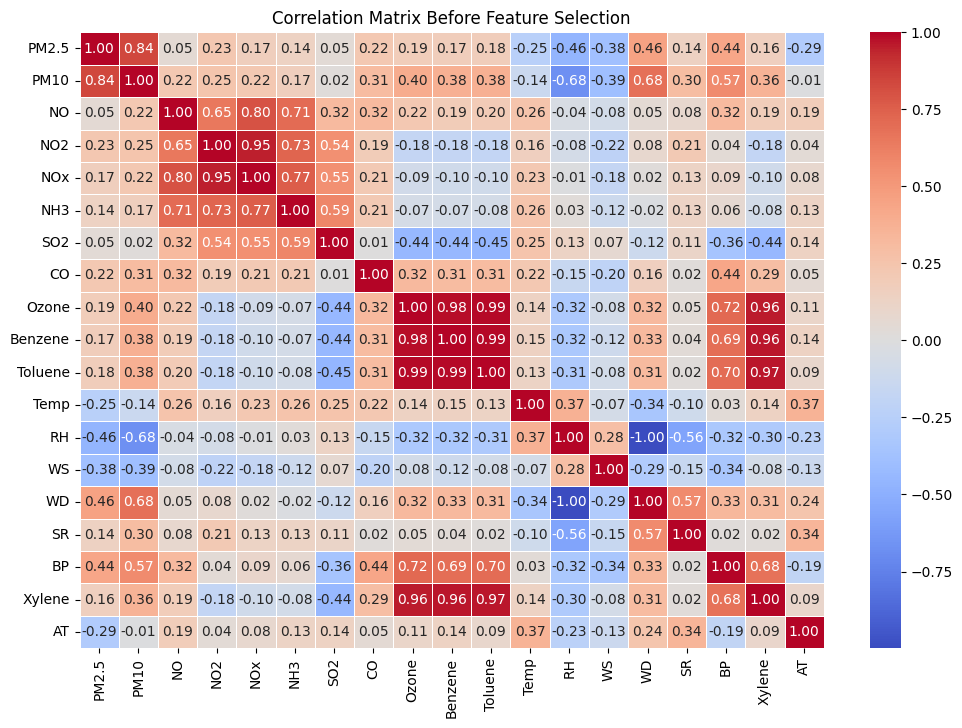

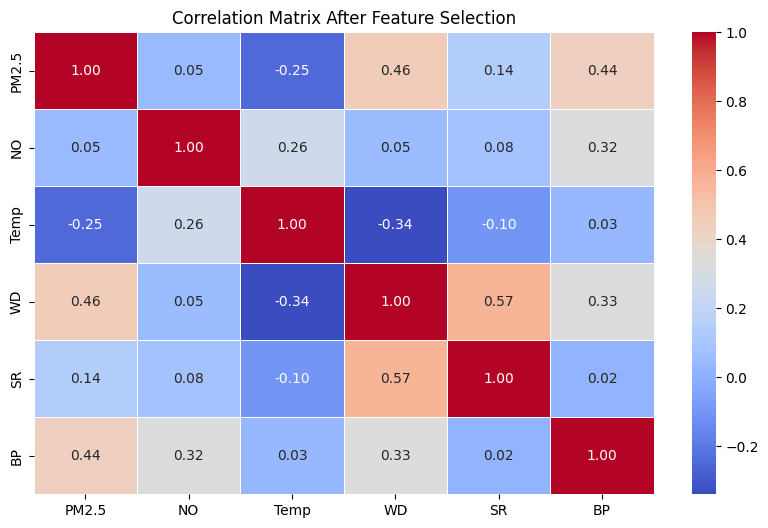

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 953.4555 - mae: 30.7288 - val_loss: 743.8089 - val_mae: 26.9117
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 975.9881 - mae: 28.5393 - val_loss: 359.4700 - val_mae: 16.9232
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 274.8071 - mae: 13.8826 - val_loss: 48.3937 - val_mae: 5.5710
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 78.4757 - mae: 6.9479 - val_loss: 22.8864 - val_mae: 3.8680
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 31.6166 - mae: 4.4962 - val_loss: 12.7377 - val_mae: 2.8257
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 23.3190 - mae: 3.8719 - val_loss: 11.4789 - val_mae: 2.6943
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 28.4851 - mae: 4.1433 - val_loss: 14.0914 - val_mae: 3.0339
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 27.5203 - mae: 3.9216 - val_loss: 10.4221 - val_mae: 2.5044
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 

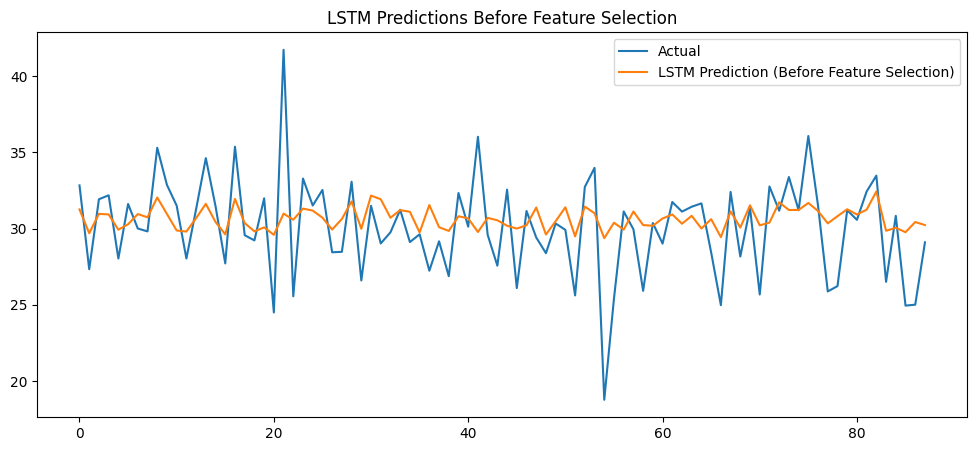

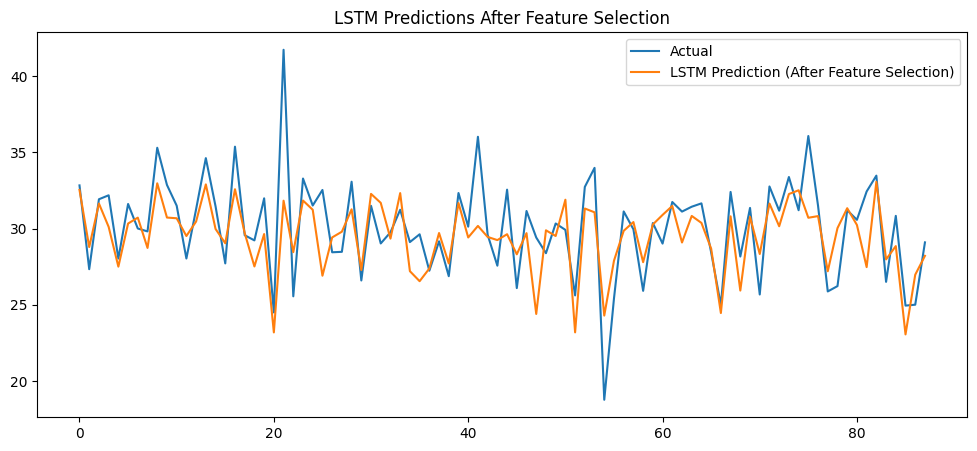

LSTM Model MAE Before Feature Selection: 2.19778298811479
LSTM Model MAE After Feature Selection: 1.7233094041997739


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape

# Load dataset
file_path = '/content/Data_Air Pollutant.xlsx'  # Updated file path
df = pd.read_excel(file_path)

# Preprocessing: Handle missing values
df.dropna(inplace=True)

# Convert date column (if present) to datetime and extract useful features
if df.iloc[:, 0].dtype == object:
    try:
        df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], format='%d-%m-%Y %H:%M', errors='coerce')
        df.dropna(subset=[df.columns[0]], inplace=True)  # Drop rows with invalid dates
        df['Year'] = df.iloc[:, 0].dt.year
        df['Month'] = df.iloc[:, 0].dt.month
        df['Day'] = df.iloc[:, 0].dt.day
        df['Hour'] = df.iloc[:, 0].dt.hour
        df.drop(df.columns[0], axis=1, inplace=True)  # Drop original date column
    except Exception as e:
        print(f"Error converting date column: {e}")

# Ensure all columns are numeric
df = df.select_dtypes(include=[np.number])

# Correlation matrix before feature selection
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Before Feature Selection")
plt.show()

# Splitting features and target (Assume last column is the target)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Feature Selection using Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = rf.feature_importances_

# Selecting important features
important_features = X.columns[feature_importances > np.mean(feature_importances)]  # Select important features
X_selected = X[important_features]

# Correlation matrix after feature selection
plt.figure(figsize=(10, 6))
sns.heatmap(X_selected.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix After Feature Selection")
plt.show()

# Train-test split (Before Feature Selection)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42)

# Train-test split (After Feature Selection)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test_full = scaler.transform(X_test_full)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshaping for LSTM input
X_train_full = X_train_full.reshape((X_train_full.shape[0], X_train_full.shape[1], 1))
X_test_full = X_test_full.reshape((X_test_full.shape[0], X_test_full.shape[1], 1))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Function to create LSTM model
def create_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train LSTM model before feature selection
lstm_full = create_lstm((X_train_full.shape[1], 1))
lstm_full.fit(X_train_full, y_train_full, epochs=50, batch_size=16, verbose=1, validation_data=(X_test_full, y_test_full))

# Predictions before feature selection
y_pred_full = lstm_full.predict(X_test_full)

# Train LSTM model after feature selection
lstm_selected = create_lstm((X_train.shape[1], 1))
lstm_selected.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test, y_test))

# Predictions after feature selection
y_pred_selected = lstm_selected.predict(X_test)

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(y_test_full.values, label='Actual')
plt.plot(y_pred_full, label='LSTM Prediction (Before Feature Selection)')
plt.legend()
plt.title("LSTM Predictions Before Feature Selection")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_selected, label='LSTM Prediction (After Feature Selection)')
plt.legend()
plt.title("LSTM Predictions After Feature Selection")
plt.show()

# Evaluate models
mae_full = np.mean(np.abs(y_pred_full.flatten() - y_test_full))
mae_selected = np.mean(np.abs(y_pred_selected.flatten() - y_test))
print(f"LSTM Model MAE Before Feature Selection: {mae_full}")
print(f"LSTM Model MAE After Feature Selection: {mae_selected}")

Evaluation Metrics (with ReLU):
Mean Absolute Error (MAE): 5.487721671087023
Mean Squared Error (MSE): 51.10255755346125
Root Mean Squared Error (RMSE): 7.14860528728935
Standard Deviation of Actual PM2.5: 15.80605629821934
Standard Deviation of Predicted PM2.5 (ReLU): 14.805227846820307


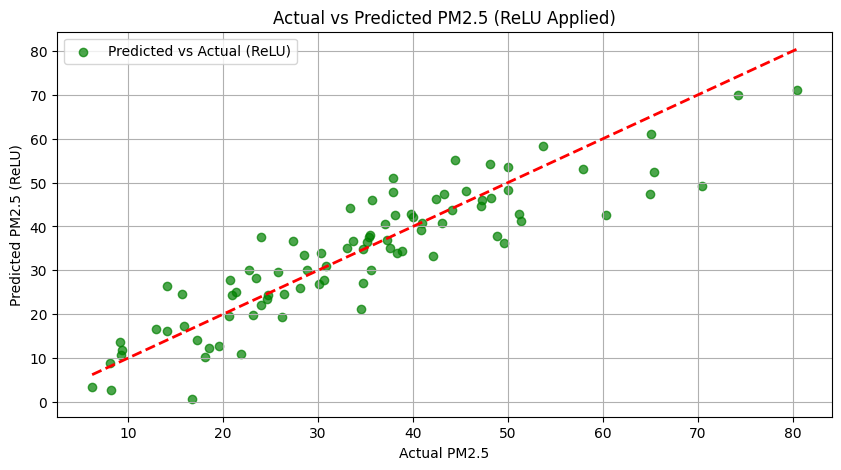

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the file path
file_path = "Data_Air Pollutant.xlsx"

# Check if the file exists
if not os.path.exists(file_path):
    print(f"Error: File '{file_path}' not found. Please check the file path.")
else:
    # Load the dataset
    df = pd.read_excel(file_path, sheet_name="Sheet1")

    # Drop non-numeric and date columns
    df_numeric = df.drop(columns=["From Date", "To Date"], errors="ignore")

    # Convert non-numeric columns to numeric
    df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')

    # Drop missing values
    df_numeric = df_numeric.dropna()

    # Features and target
    X = df_numeric.drop(columns=["PM2.5"])
    y = df_numeric["PM2.5"]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Predict and apply ReLU
    y_pred = model.predict(X_test_scaled)
    y_pred_relu = np.maximum(0, y_pred)  # Apply ReLU

    # Evaluation
    mae = mean_absolute_error(y_test, y_pred_relu)
    mse = mean_squared_error(y_test, y_pred_relu)
    rmse = mse ** 0.5
    std_actual = np.std(y_test)
    std_predicted = np.std(y_pred_relu)

    print("Evaluation Metrics (with ReLU):")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Standard Deviation of Actual PM2.5: {std_actual}")
    print(f"Standard Deviation of Predicted PM2.5 (ReLU): {std_predicted}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred_relu, alpha=0.7, color="green", label="Predicted vs Actual (ReLU)")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel("Actual PM2.5")
    plt.ylabel("Predicted PM2.5 (ReLU)")
    plt.title("Actual vs Predicted PM2.5 (ReLU Applied)")
    plt.legend()
    plt.grid(True)
    plt.show()
